## Lecture 2

#### Announcements

* Reminder that solutions for P01 and P02 are due Sunday night. Please typeset your answers.

#### Demo: Anaconda Navigator

Show how to set up a Python environment for this course on Windows using Anaconda Navigator.

#### Goals

* Know what is meant by image noise.
* Know how to filter (v) an image by cross-correlating it with a given filter (n)/kernel/weights
* Know how to handle image borders when filtering:
  - output sizes: full / same / valid
  - out-of-bounds values: zeros, reflection, replication
* Get a feel for some of the image processing operations that can and can't be accomplished using linear filtering.
  * Blur, sharpen, shift

* Know the properties of the convolution and cross-correlation, and some of their implications:
  * linearity, associativity, commutativity
  * separable filters and other compound operations

#### Lesson Plan

**Syllabus questions**

**Discussion: Final Exam or Final Project?**

Revisiting image formation: image noise

Noise as motivation for **neighborhood operations**

Live code: mean filter

Edge handling choices:

* full, same, valid output size
* zero, reflect, repeat

Write down the discrete math definition; aside: write down the continuous definition

Live code: generalize to cross-correlation with filter weights

Mess with the filter weights:

* Horizontal blur
* Emboss

Exercise: compute a small cross-correlation result

**Break**

More filter weights:

* Left shift

Convolution vs cross-correlation

Properties - shift invariance; linearity; commutativity; associativity

Filter composition using associativity

Tricks using these properties:

* separable filters
* Blurring sequentially
* Sharpening

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering

#### Image Formation Revisited

How do we record light intensity inside a camera?
* Film
* Digital sensors

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/2014_Ziarno_na_fotografii_analogowej.jpg/1920px-2014_Ziarno_na_fotografii_analogowej.jpg)
![](digital_noise.jpg)


Let's make beans a little noisy.

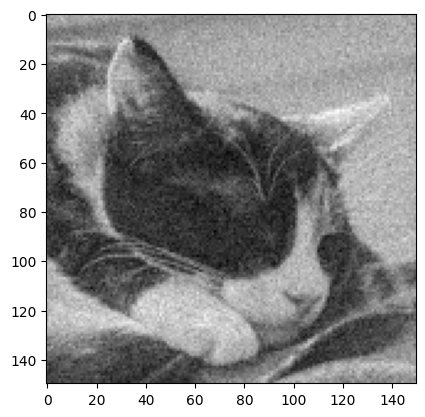

In [2]:
# don't worry about the details here, we're just adding noise to beans
beans = imageio.imread("../data/beans.jpg")
bg = skim.color.rgb2gray(beans)
bg = skim.transform.rescale(bg, 0.25, anti_aliasing=True)
bn = bg + np.random.randn(*bg.shape) * 0.05
plt.imshow(bn, cmap="gray")

### Brainstorm

If each pixel measurement is corrupted, how can we improve our guess at what the "ideal" image should have been?

Idea: mean filter

Live-pseudocode:
```python
def mean_filter(img, filter_size):
    assert (filter_size % 2 == 1)
    height = img.shape[0]
    width = img.shape[1]
    for r in range(0, height): # - something? :(
        for c in range(0, width): # adjust this too? :(
            l = filter_size // 2
            total = 0
            for patch_r in range(-l, l+1):
                for patch_c in range(-l, l+1):
                    total += img[r+patch_r, c+patch_c]

            img[r, c] = total / (filter_size ** 2)
```

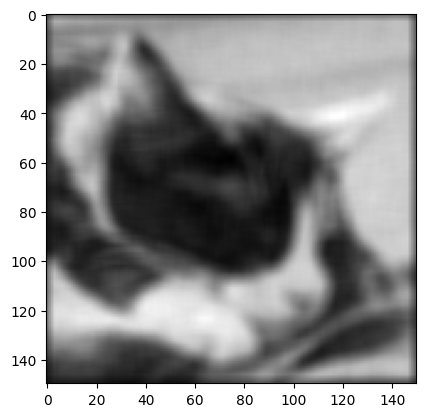

In [5]:
# Look at mean_filter
plt.imshow(filtering.mean_filter(bn, 7), cmap="gray")

#### Design Decisions - edge handling

**(whiteboard)**

Edge handling:
* zero-pad
* avg-pad
* repeat edge values
* cyclic edges (warp-around)

Output size:
* valid (only output where the whole filter overlaps the image)
* same (output same size as input)
* full (output everywhere the filter overlaps the image even a little bit)

For anything but valid, how do you handle when the filter hangs over the void?
* Zero padding
* Repeat (replicate) padding
* Reflect padding

#### Is a mean filter the best we can do?

Another example


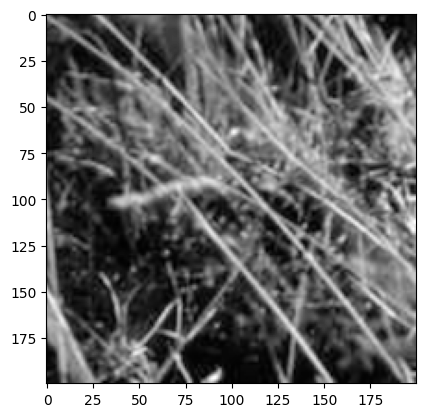

In [22]:
sticks = skim.color.rgb2gray(imageio.imread("../data/sticks.png"))

plt.imshow(sticks, cmap="gray")

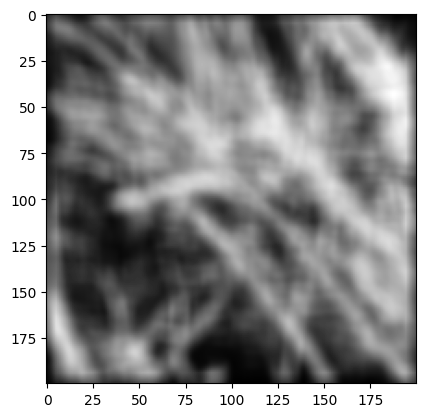

In [23]:
plt.imshow(filtering.mean_filter(sticks, 11), cmap="gray")

See the lattice-like artifacts? Ick. Why is this happening?

Alternatives?
* 

Here's one:

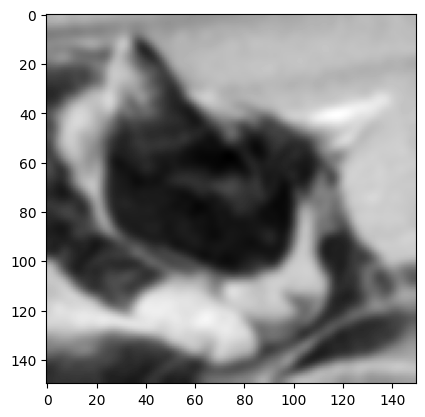

In [14]:
plt.imshow(cv2.GaussianBlur(bn, ksize=(9,9), sigmaX=2), cmap="gray")

TODO: implement filtering.filter

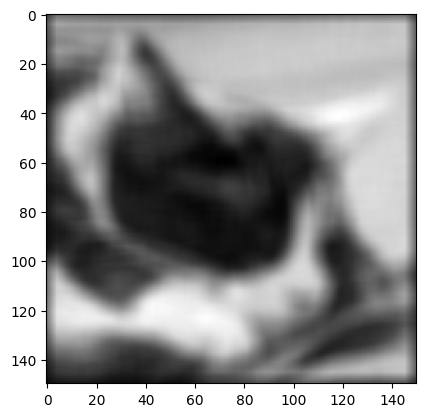

In [15]:
# test out the case of the mean filter we've been using
f = np.ones((9,9)) / (9*9)

plt.imshow(filtering.filter(bn, f), cmap="gray")


In [16]:
# don't look behind the curtain!
g = np.zeros((9, 9))
g[4,4] = 1
g = cv2.GaussianBlur(g, ksize=(9, 9), sigmaX=2)
g /= g.sum()

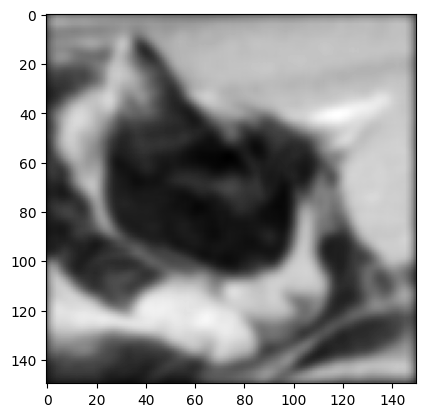

In [17]:
plt.imshow(filtering.filter(bn, g), cmap="gray")

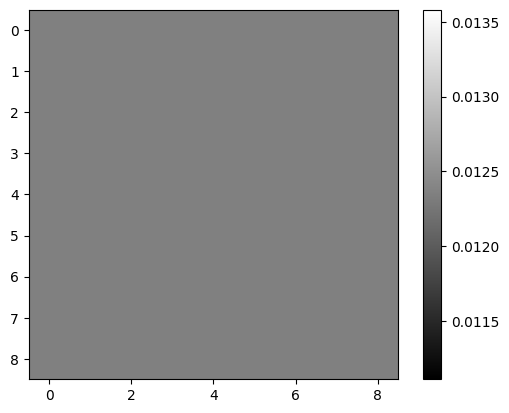

In [18]:
plt.imshow(f, cmap="gray")
plt.colorbar()

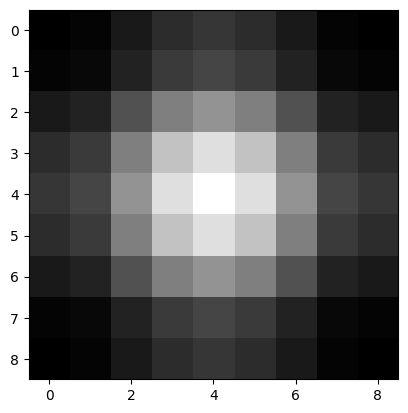

In [19]:
plt.imshow(g, cmap="gray")

### How would we calculate a Gaussian kernel ourselves?

$$G(x, y) = \frac{1}{2 \pi \sigma^2} e^{-\frac{x^2 + y^2}{2 \sigma^2}}$$

where:
* $x, y$ are the spatial dimensions of the filter with (0,0) in the **center** of the kernel
* $\sigma$ is the standard deviation of the Gaussian, (determines how wide and flat vs tall and pointy it is)

Practicalities when calculating this in real life:
* You generally have to choose both a kernel size and a $\sigma$.
    * For a given kernel size, you can choose sigma so it fits $\pm$ 3 standard deviations, $\sigma = (k-1)/6$
    * Or for a given sigma, the kernel size that fits $\pm$ 3 standard deviations is $k = 2*\mathrm{ceil}(3*\sigma)+1$
* Not all the mass under the Gaussian fits in a finite kernel, so we usually renormalize the kernel so the weights sum to 1.

#### HW Problems 1 - 4

(1) $f \otimes w$ indicates the *cross-correlation* of image $f$ with filter $w$. Compute the following cross-correlation using **same** output size and **zero** padding.
   $$
   \begin{bmatrix}
     0 & 1 & 0\\
     0 & 1 & 0\\
     0 & 1 & 0
   \end{bmatrix} \otimes
   \begin{bmatrix}
     1 & 2 & 1\\
     2 & 4 & 2\\
     1 & 2 & 1
   \end{bmatrix}
   $$

(2) Perform the same convolution as above, but use **repeat** padding.

(3) Perform the same convolution as above, but use **valid** output size.

(4) Describe in words the result of applying the following filter using cross-correlation. If you aren't sure, try applying it to the image above to gain intuition.

$$
\begin{bmatrix}
  0 & 0 & 0\\
  0 & 0 & 1\\
  0 & 0 & 0
\end{bmatrix}
$$

### What else could we do with this?

Let's mess with filter weights to do weird stuff.

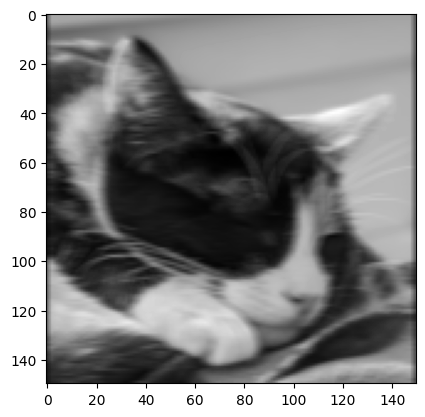

In [24]:
h = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]],dtype=np.float64) / 5
    
plt.imshow(filtering.filter(bg, h), cmap="gray")

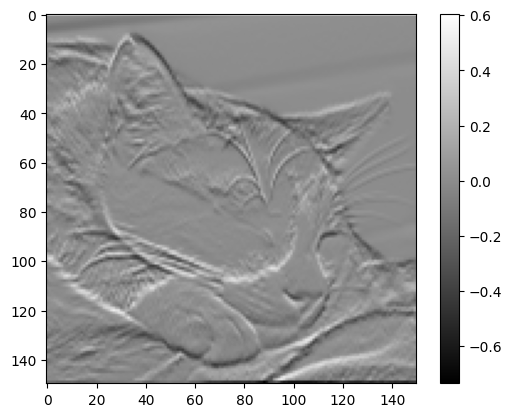

In [53]:
h = np.array([
    [0,  1,  1,  1,  0],
    [1,  -1,  -1,  -1,  1],
    [1,  -1,  -1,  -1,  1],
    [1,  -1,  -1, -1,  1],
    [0,  1,  1,  1, 0]], dtype=np.float64)
h = np.array([[-1, 0, 1]]).T

plt.imshow(filtering.filter(bg, h), cmap="gray")
plt.colorbar();

## **Break**

#### Math definitions

Discrete cross-correlation:

$$
(f \otimes g)(x, y) = \sum_{j=-\ell}^\ell \sum_{k=-\ell}^\ell f(x+j, y+k) * g(j, k)
$$

Turns out there's a continuous version of this too! Sums become integrals:

$$
(f \otimes g)(x, y) = \int_{j=-\infty}^\infty \int_{k=-\infty}^\infty f(x+j, y+k) * g(j, k)
$$
Why $\infty$? Assume zero outside the boundaries.

### Properties of Cross-Correlation

Convolution vs cross-correlation

Properties 
* Linearity: if $a$ is a scalar, $f$ is an image, and $g$, $h$ are filters, then:
$$\begin{align*}
a(f \otimes g) = f \otimes ag = af \otimes g \\
(f \otimes g) + (f \otimes h) = f \otimes (g + h)
\end{align*}$$
* Associativity
  $$
  f \otimes (g \otimes h) = (f \otimes g) \otimes h
  $$
* Commutativity?
  $$
  f \otimes g \overset{?}{=} g \otimes f
  $$
  Check:
     $$
   \begin{bmatrix}
     0 & 0 & 0\\
     0 & 1 & 0\\
     0 & 0 & 0
   \end{bmatrix} \otimes
   \begin{bmatrix}
     1 & 2 & 3\\
     4 & 5 & 6\\
     7 & 8 & 9
  \end{bmatrix}
    \overset{?}{=}
    \begin{bmatrix}
     1 & 2 & 3\\
     4 & 5 & 6\\
     7 & 8 & 9
  \end{bmatrix}
  \otimes
  \begin{bmatrix}
     0 & 0 & 0\\
     0 & 1 & 0\\
     0 & 0 & 0
   \end{bmatrix} 
  $$

**Aside:** The filter above (with just a 1 in the middle is called the **identity** filter.

### Convolution

A small modification to cross-correlation yields **Convolution**:

Cross-correlation ($\otimes$):
$$
(f \otimes g)(x, y) = \sum_{j=-\ell}^\ell \sum_{k=-\ell}^\ell f(x+j, y+k) * g(j, k)
$$
Convolution ($*$):
$$
(f * g)(x, y) = \sum_{j=-\ell}^\ell \sum_{k=-\ell}^\ell f(x-j, y-k) * g(j, k)
$$

This effectively **flips** the filter horizontally and vertically before applying it, and gains us **commutativity**.

### Okay, what can we do with these properties?

#### We can blur, but can we sharpen?

Key question: what did blurring remove?

$I - blur(I)$


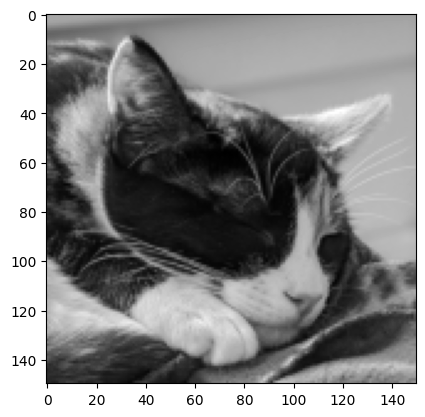

In [41]:
orig = bg
blurred = filtering.filter(bg, g)
lost = orig - blurred

plt.imshow(orig, cmap="gray")



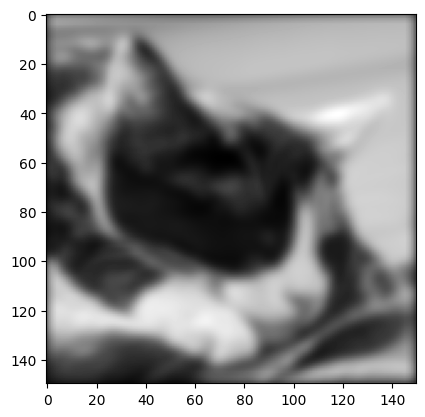

In [42]:
plt.imshow(blurred, cmap="gray")

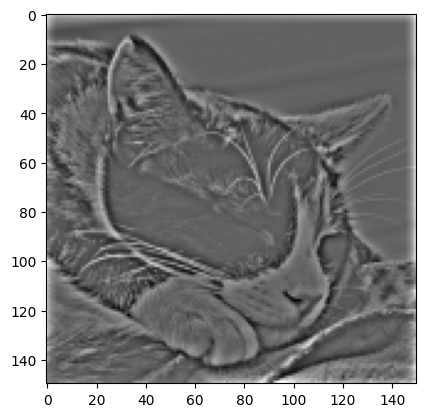

In [43]:
plt.imshow(lost, cmap="gray")

What if we add back what's lost?

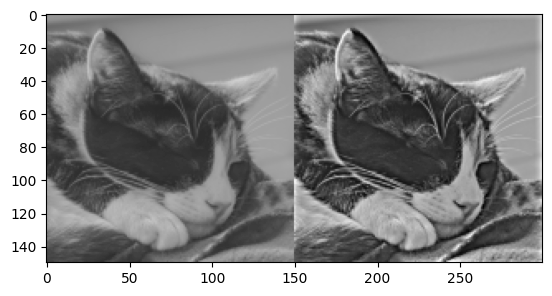

In [48]:
plt.imshow(np.hstack([orig, orig + 1.3 * lost]), cmap="gray")

(whiteboard - equations here for posterity)
\begin{align*}
I' &= I + (I - (I * G))\\
   &= (I + I) - (I * G))\\
   &= (I * D) - (I * G)\\
   &= I * (D - G)\\
\end{align*}

Visual intuition:

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*tvgDlagu7Tm7q7Y2Y6Gs0g.png)

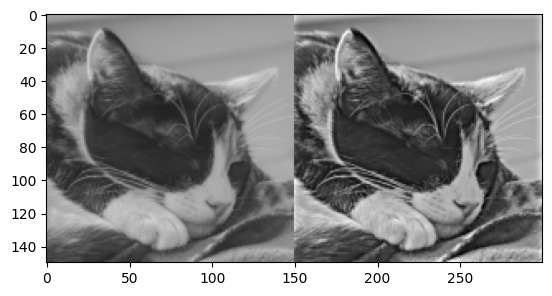

In [49]:
d  = np.zeros_like(g)
d[4, 4] = 2

sharp = d - g

sharpened = filtering.filter(bg, sharp)
plt.imshow(np.hstack([orig, sharpened]), cmap="gray")



#### Efficiency trick: separable filters

**Homework Problems 9-10**: 

9. Compute a 3x3 filter by convolving the following $1 \times 3$ filter with its transpose using **full** output size and zero padding:
   $$
   \begin{bmatrix}
     1 & 2 & 1\\
   \end{bmatrix}
   $$

10. Suppose you have an  image $F$ and you want to apply a $3 \times 3$ filter $H$ like the one above that can be written as $H = G * G^T$, where $G$ is $1 \times 3$. Which of the following will be more efficient?
   * $F * (G * G^T)$ 
   * $(F * G) * G^T$

### What *can't* we do with convolution?

**Homework Problem 11**: 

(11) For each of the following, decide whether it's possible to design a convolution filter that performs the given operation.

* Max filter: the output pixel is the maximum value among the pixels in the input window
* Threshold: the output pixel is

  * 255 if the input pixel is > 127
  * 0 otherwise
* $y$ partial derivative: the output is a finite-differences approximation of the input image's vertical derivative $\frac{\partial}{\partial y}  f(x, y)$[^1] .